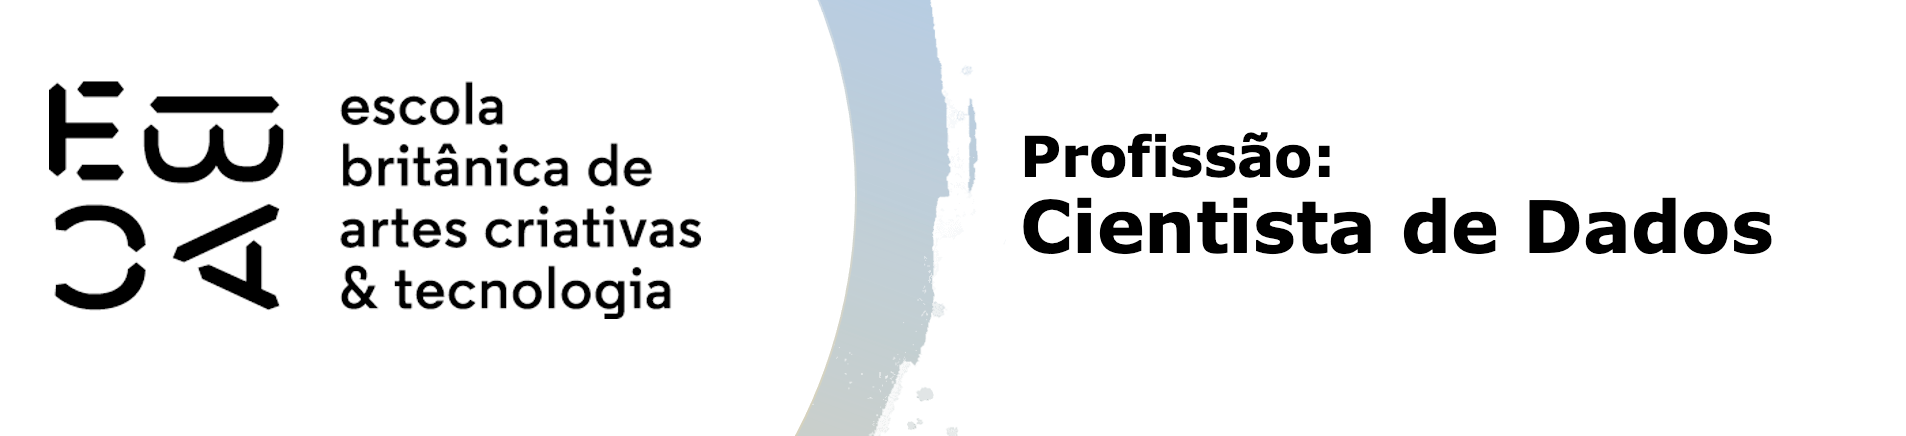

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report


In [161]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [163]:
# Obter os últimos 3 valores únicos de 'data_ref'
ultimos_3 = sorted(df['data_ref'].unique())[-3:]

# Separar os dados em treino e validação OOT
df_treino = df[~df['data_ref'].isin(ultimos_3)].drop(columns=['data_ref', 'index']).copy()
df_oot = df[df['data_ref'].isin(ultimos_3)].drop(columns=['data_ref', 'index']).copy()

# Exibir os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {df_treino.shape}")
print(f"Tamanho do conjunto de OOT: {df_oot.shape}")

Tamanho do conjunto de treino: (600000, 13)
Tamanho do conjunto de OOT: (150000, 13)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [165]:
# Número total de linhas
linhas_total = df.shape[0]

# Número de linhas por mês em data_ref
linhas_por_mes = df['data_ref'].value_counts().sort_index()

print(f"Número total de linhas: {linhas_total}")
print("Número de linhas por mês em data_ref:")
print(linhas_por_mes)

Número total de linhas: 750000
Número de linhas por mês em data_ref:
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64


In [166]:
# Identificação das variáveis qualitativas e quantitativas
qualitativas = df.select_dtypes(include=['object', 'category']).columns
quantitativas = df.select_dtypes(include=['number']).columns

# Descritiva para variáveis qualitativas
print("### Descritiva das variáveis qualitativas ###")
for col in qualitativas:
    print(f"\n{col}:\n{df[col].value_counts().to_string()}")

# Descritiva para variáveis quantitativas
print("\n### Descritiva das variáveis quantitativas ###")
df[quantitativas].describe().T

### Descritiva das variáveis qualitativas ###

sexo:
F    504580
M    245420

posse_de_veiculo:
N    457954
S    292046

posse_de_imovel:
S    503692
N    246308

tipo_renda:
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361

educacao:
Médio                  506836
Superior completo      204306
Superior incompleto     29471
Fundamental              8575
Pós graduação             812

estado_civil:
Casado      526472
Solteiro     91659
União        57685
Separado     42571
Viúvo        31613

tipo_residencia:
Casa             674294
Com os pais       33232
Governamental     23440
Aluguel           10349
Estúdio            5395
Comunitário        3290

### Descritiva das variáveis quantitativas ###


,count,mean,std,min,25%,50%,75%,max
index,750000.0,8319.272793,4809.281774,0.000000,4147.000000,8324.000000,12487.000000,1.664900e+04
qtd_filhos,750000.0,0.433251,0.739379,0.000000,0.000000,0.000000,1.000000,1.400000e+01
idade,750000.0,43.804733,11.229868,22.000000,34.000000,43.000000,53.000000,6.800000e+01
tempo_emprego,624043.0,7.748574,6.687455,0.117808,3.049315,6.046575,10.183562,4.290685e+01
qt_pessoas_residencia,750000.0,2.212241,0.903428,1.000000,2.000000,2.000000,3.000000,1.500000e+01
renda,750000.0,23238.544747,79106.013795,107.670000,3467.700000,7861.820000,18318.280000,4.083986e+06


In [167]:
# Separando as variáveis qualitativas
qualitativas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
                'educacao', 'estado_civil', 'tipo_residencia']

# Separando as variáveis quantitativas
quantitativas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

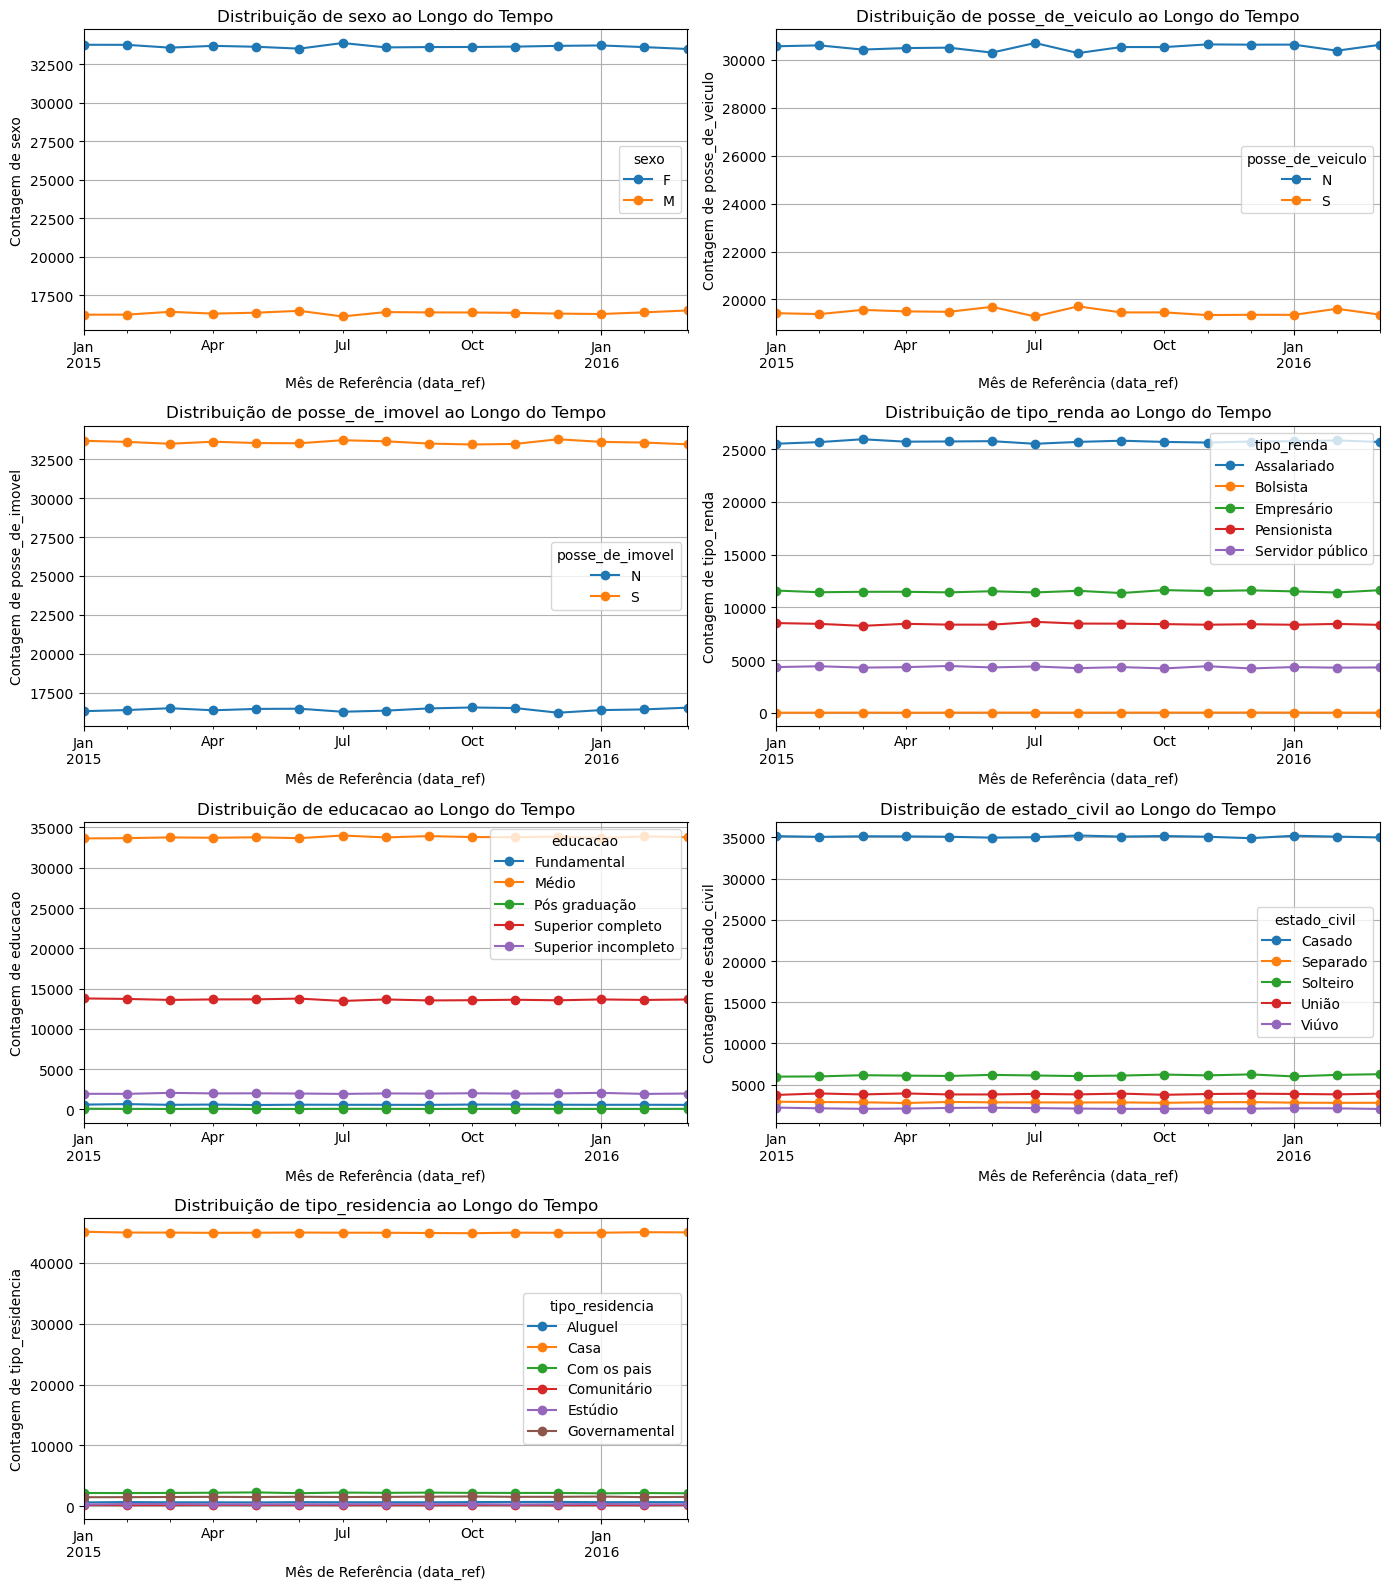

In [168]:
# Configuração dos subplots: ajusta automaticamente com base no número de variáveis qualitativas
num_vars = len(qualitativas)
cols = 2  # Número de colunas no layout
rows = (num_vars + 1) // cols  # Calcula o número de linhas necessárias

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))  # Ajusta o tamanho dos gráficos dinamicamente

# Flatten the axes array para iterar mais facilmente
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(qualitativas):
    df.groupby(['data_ref', var]).size().unstack().plot(
        marker='o', linestyle='-', ax=axes[i]
    )
    axes[i].set_title(f'Distribuição de {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel(f'Contagem de {var}')
    axes[i].grid(True)

# Remover subplots vazios, se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

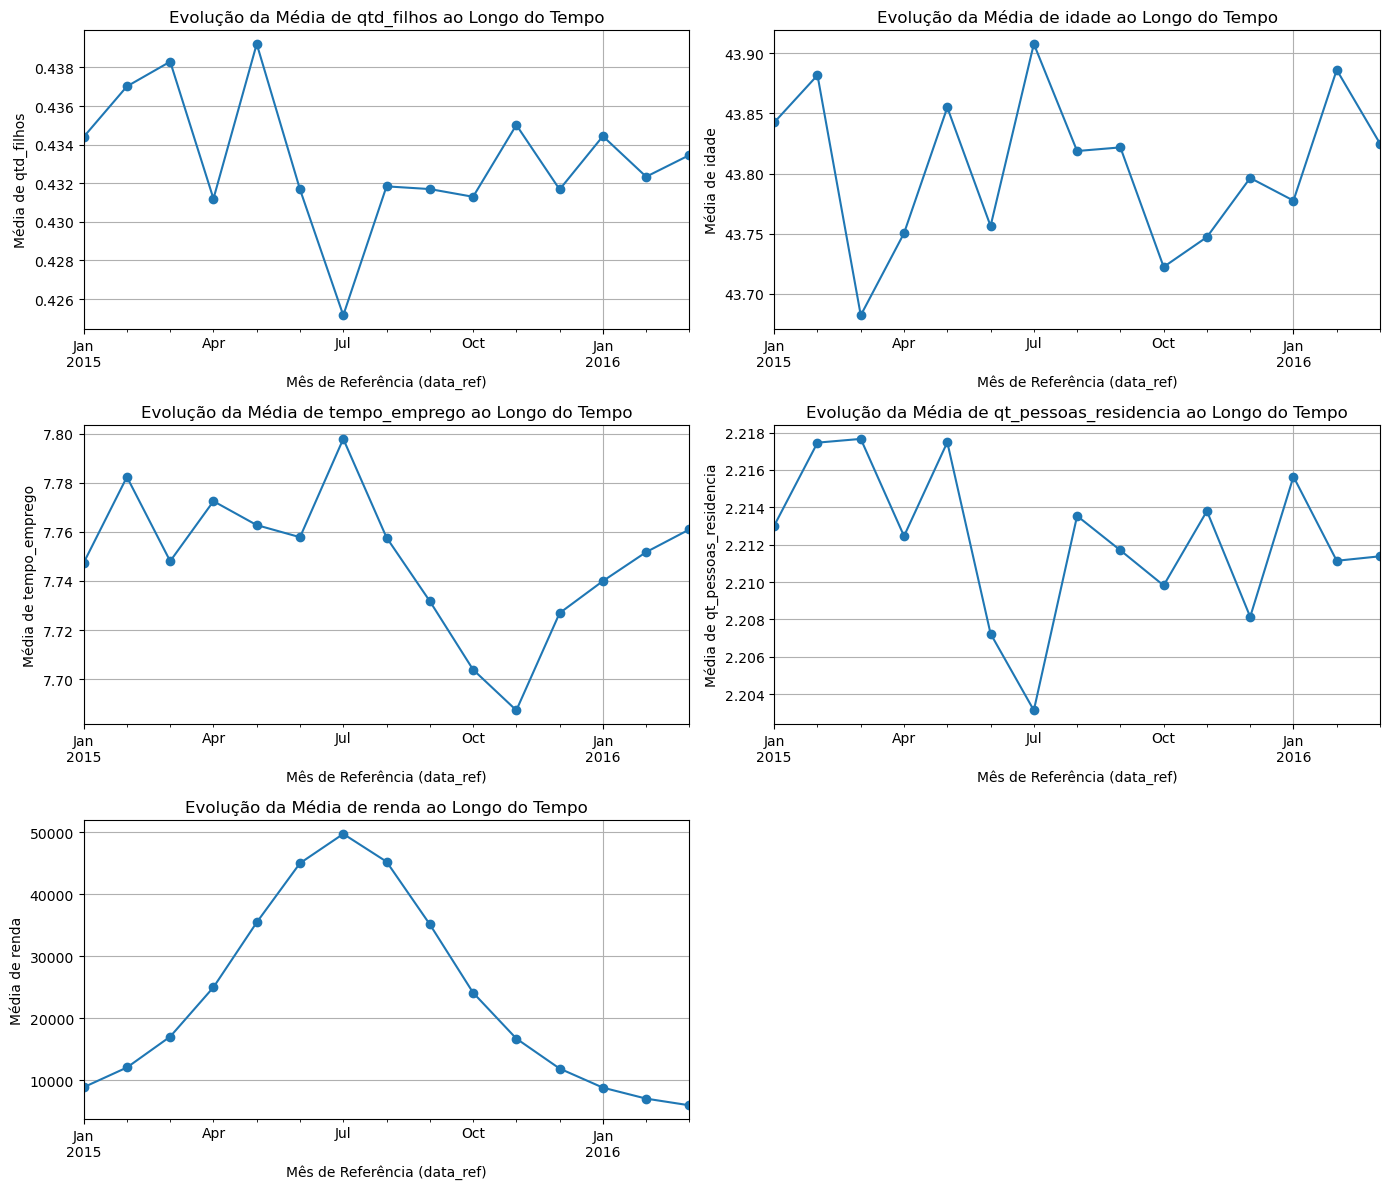

In [169]:
# Configuração dinâmica dos subplots com base no número de variáveis quantitativas
num_vars = len(quantitativas)
cols = 2  # Número de colunas no layout
rows = (num_vars + 1) // cols  # Calcula o número de linhas necessárias

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))  # Ajusta tamanho do gráfico dinamicamente

# Flatten the axes array para facilitar a iteração
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(quantitativas):
    df.groupby('data_ref')[var].mean().plot(marker='o', linestyle='-', ax=axes[i])
    axes[i].set_title(f'Evolução da Média de {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel(f'Média de {var}')
    axes[i].grid(True)

# Remover subplots vazios, se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


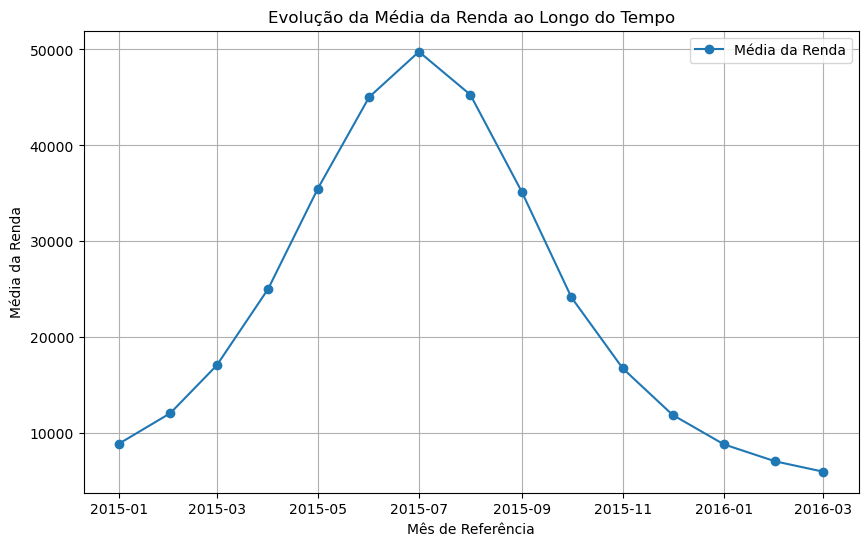

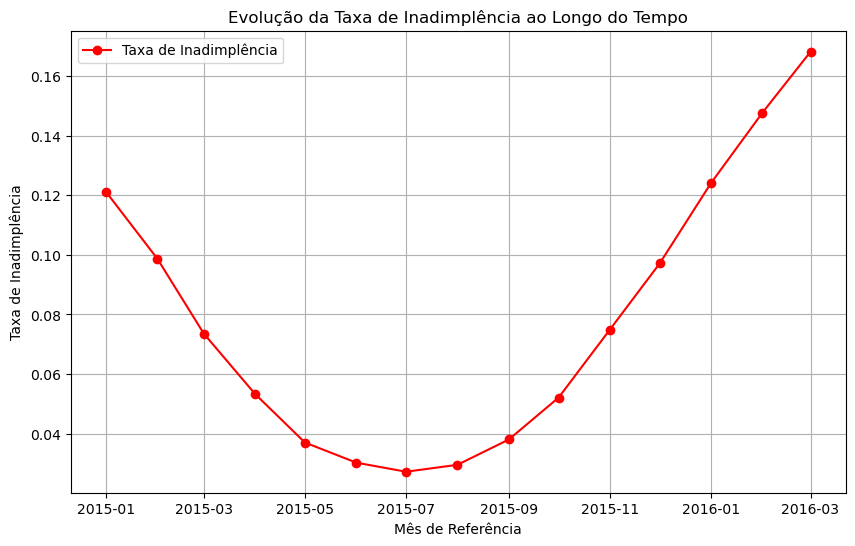

In [170]:
# Evolução da média da renda ao longo do tempo
renda_media_por_mes = df.groupby('data_ref')['renda'].mean()

plt.figure(figsize=(10, 6))
plt.plot(renda_media_por_mes.index, renda_media_por_mes.values, marker='o', label='Média da Renda')
plt.title('Evolução da Média da Renda ao Longo do Tempo')
plt.xlabel('Mês de Referência')
plt.ylabel('Média da Renda')
plt.grid(True)
plt.legend()
plt.show()

# Evolução da taxa de inadimplência ao longo do tempo
# Assumindo que a variável de inadimplência seja binária (0 ou 1)
inadimplencia_por_mes = df.groupby('data_ref')['mau'].mean()

plt.figure(figsize=(10, 6))
plt.plot(inadimplencia_por_mes.index, inadimplencia_por_mes.values, marker='o', color='red', label='Taxa de Inadimplência')
plt.title('Evolução da Taxa de Inadimplência ao Longo do Tempo')
plt.xlabel('Mês de Referência')
plt.ylabel('Taxa de Inadimplência')
plt.grid(True)
plt.legend()
plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

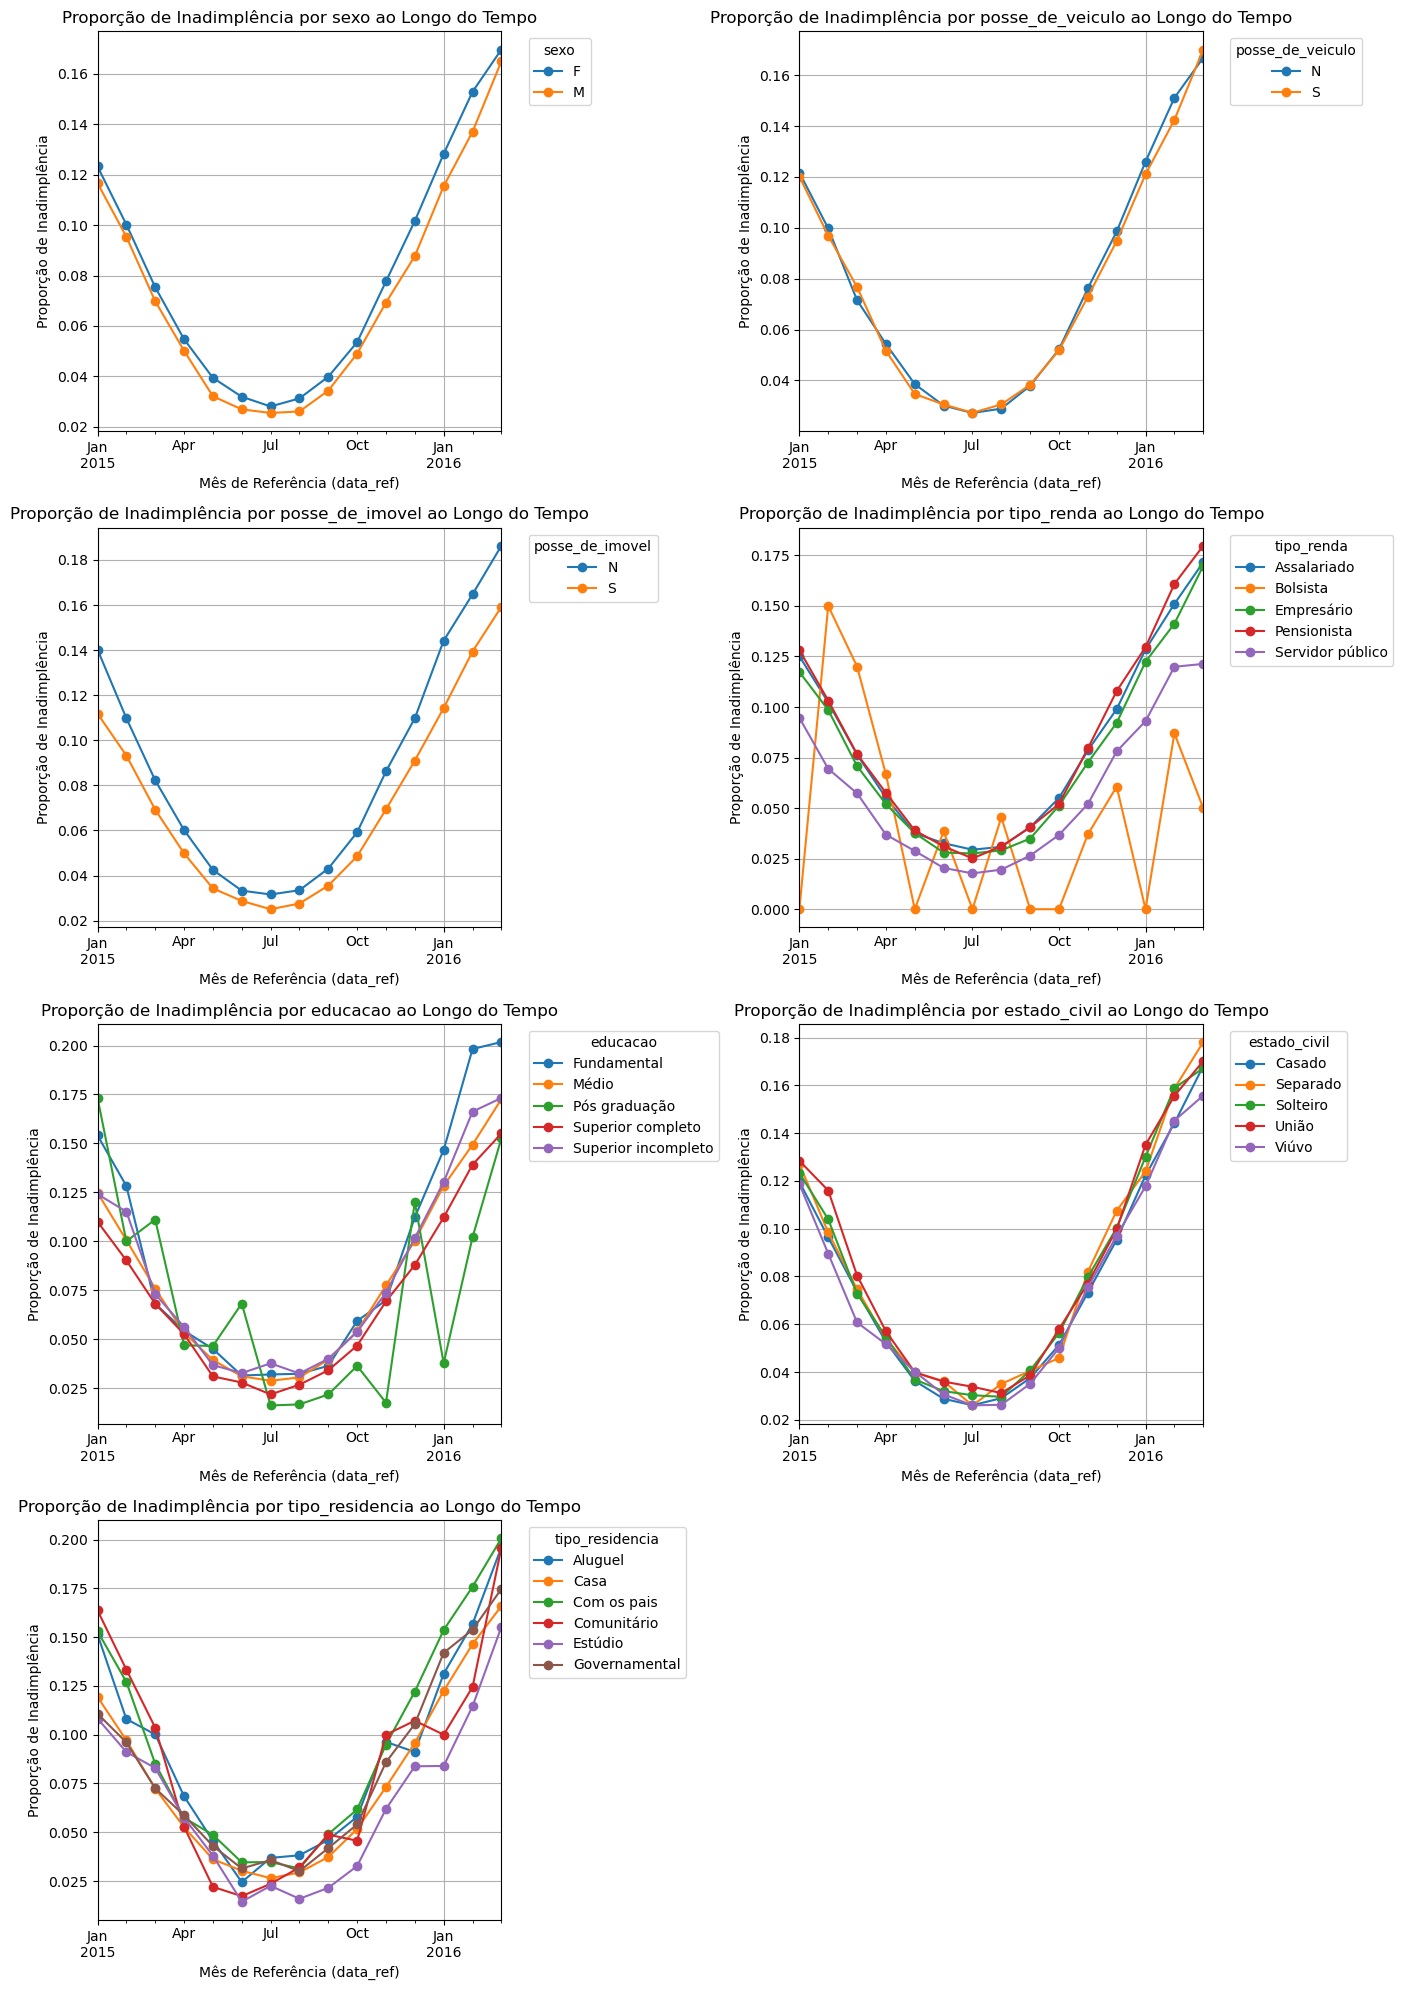

In [172]:
# Configuração dos subplots: 4 linhas e 2 colunas
fig, axes = plt.subplots(4, 2, figsize=(14, 20))  # Tamanho ajustado para melhor visualização

# Achatar o array de eixos para fácil iteração
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(qualitativas):
    # Calcular a proporção de inadimplência por data_ref e variável qualitativa
    data = df.groupby(['data_ref', var])['mau'].mean().unstack()
    
    # Plotar o gráfico
    data.plot(marker='o', linestyle='-', ax=axes[i])
    
    # Configurações do gráfico
    axes[i].set_title(f'Proporção de Inadimplência por {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel('Proporção de Inadimplência')
    axes[i].legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].grid(True)

# Remover o último subplot vazio se houver número ímpar de gráficos
if len(qualitativas) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

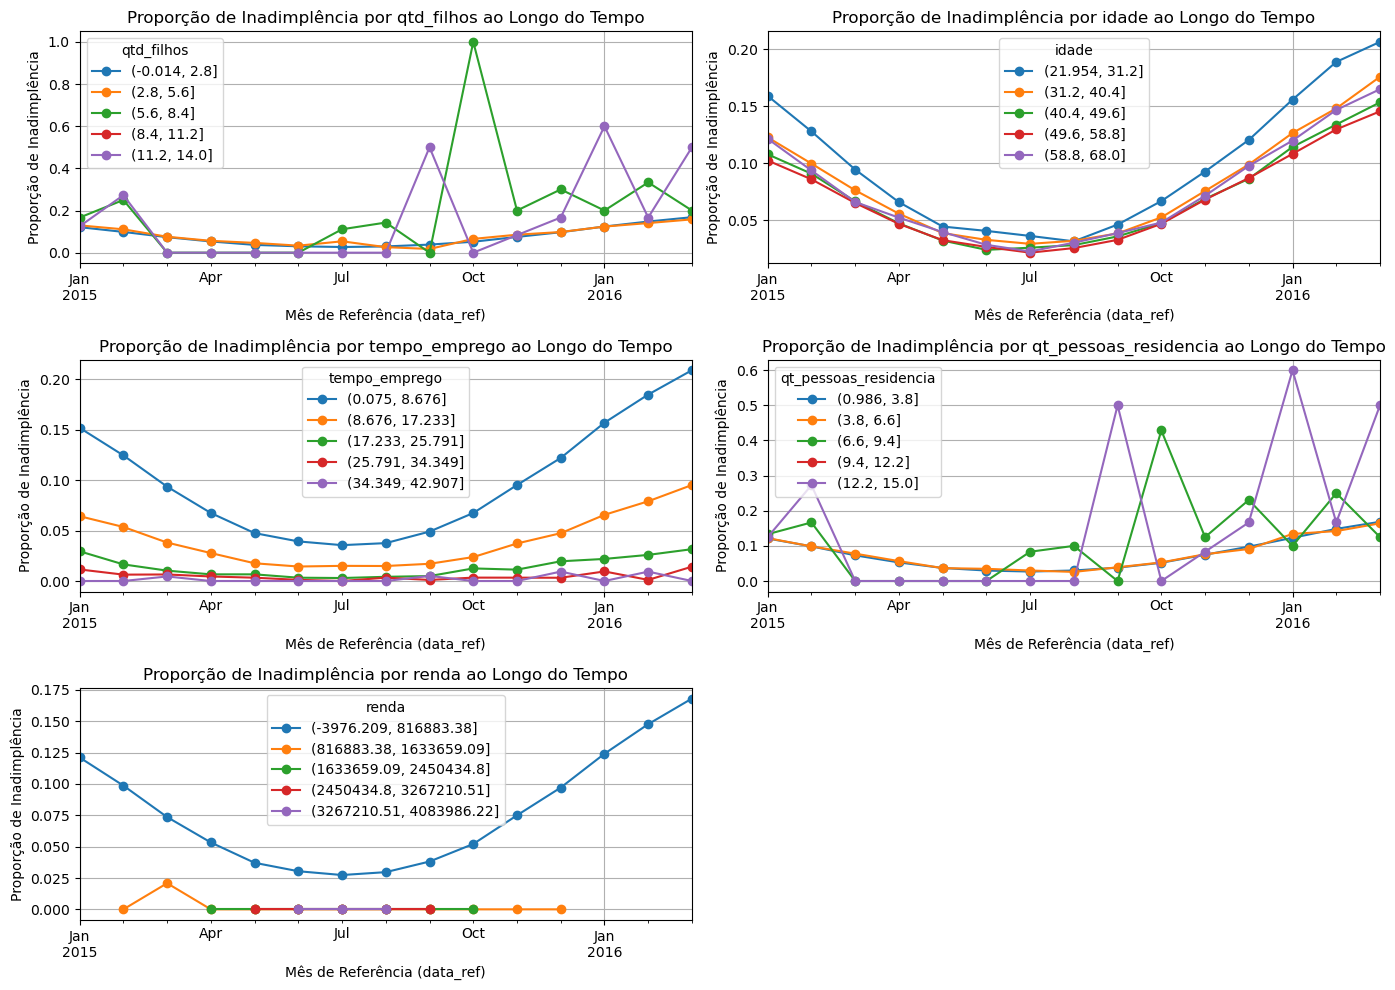

In [173]:
# Configuração dos subplots: 2 linhas e 2 colunas
fig, axes = plt.subplots(3, 2, figsize=(14, 10))  # 2 linhas para acomodar 5 gráficos, e 2 colunas

# Achatar o array de eixos para fácil iteração
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(quantitativas):
    # Calcular a proporção de inadimplência por faixas da variável quantitativa ao longo do tempo
    data = df.groupby(['data_ref', pd.cut(df[var], bins=5)], observed=False)['mau'].mean().unstack()
    data.plot(marker='o', linestyle='-', ax=axes[i])
    axes[i].set_title(f'Proporção de Inadimplência por {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel('Proporção de Inadimplência')
    axes[i].grid(True)

# Remover o último subplot vazio
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [175]:
df.isnull().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [176]:
# Excluir a variável 'posse_de_veiculo' (não discrimina)
df.drop(columns=['posse_de_veiculo'], inplace=True)

# Agrupar quantidade de filhos acima de 5 em uma única categoria "6+"
df['qtd_filhos'] = df['qtd_filhos'].apply(lambda x: '<6' if x <= 5 else '6+')

# Remover categorias 'Pensionista' e 'Bolsista' da variável 'tipo_renda'
df = df[~df['tipo_renda'].isin(['Pensionista', 'Bolsista'])]

# Agrupar "Pós-graduação" em "Superior ou mais" na variável 'educacao'
df['educacao'] = df['educacao'].replace({'Pós-graduação': 'Superior ou mais'})

# Criar nova variável 'faixa_idade', categorizando como "<30" e "30+"
df['faixa_idade'] = df['idade'].apply(lambda x: '<30' if x < 30 else '30+')

# Agrupar tempo de emprego acima de 25 anos em "25+ anos"
df['tempo_emprego'] = df['tempo_emprego'].apply(lambda x: "<25" if x < 25 else '25+ anos')

# Agrupar quantidade de pessoas na residência acima de 6 em "7+"
df['qt_pessoas_residencia'] = df['qt_pessoas_residencia'].apply(lambda x: '<7' if x <= 6 else '7+')

# Limitar a renda a valores de até 800.000 para tratar outliers
df = df[df['renda'] <= 800000]


In [177]:
df.head()

,data_ref,index,sexo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,faixa_idade
0,2015-01-01,5733,F,N,<6,Empresário,Médio,Solteiro,Casa,43,<25,<7,2515.39,False,30+
1,2015-01-01,727,F,S,<6,Assalariado,Médio,Casado,Casa,35,<25,<7,3180.19,False,30+
2,2015-01-01,6374,F,N,<6,Assalariado,Médio,Casado,Casa,31,<25,<7,1582.29,False,30+
3,2015-01-01,9566,F,N,<6,Assalariado,Médio,Casado,Casa,54,<25,<7,13721.17,False,30+
4,2015-01-01,9502,F,N,<6,Assalariado,Superior incompleto,Solteiro,Casa,31,<25,<7,2891.08,False,30+


In [178]:
# Ordenando os dados por data de referência
df_sorted = df.sort_values(by='data_ref')

# Definindo o período de corte para os últimos 3 meses
cutoff_date = df_sorted['data_ref'].max() - pd.DateOffset(months=3)

# Dividindo os dados em treino e teste com base na data
train_df = df_sorted[df_sorted['data_ref'] <= cutoff_date]
test_df = df_sorted[df_sorted['data_ref'] > cutoff_date]

# Criando variáveis dummy para as variáveis categóricas, excluindo as colunas 'mau', 'data_ref' e 'index'
X_train = pd.get_dummies(train_df.drop(columns=['mau', 'data_ref', 'index']))
X_test = pd.get_dummies(test_df.drop(columns=['mau', 'data_ref', 'index']))

# Garantindo que X_train e X_test tenham as mesmas colunas
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Definindo a variável resposta para treino e teste
y_train = train_df['mau']
y_test = test_df['mau']

In [179]:
# Ajustando o modelo de Regressão Logística com class_weight='balanced'
model = LogisticRegression(max_iter=3000, class_weight='balanced', random_state=66)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=3000, random_state=66)

In [180]:
# Ajustando o limiar para a classificação
threshold = 0.69  # Valor ajustado

# Avaliação na base de treino
y_prob_train = model.predict_proba(X_train)[:, 1]  # Probabilidades para a classe positiva na base de treino
y_pred_train_adjusted = (y_prob_train > threshold).astype(int)  # Aplicando o limiar ajustado

# Avaliação na base de teste
y_prob_test = model.predict_proba(X_test)[:, 1]  # Probabilidades para a classe positiva na base de teste
y_pred_test_adjusted = (y_prob_test > threshold).astype(int)  # Aplicando o limiar ajustado

# Matriz de Confusão e Relatório de Classificação para a base de treino
conf_matrix_train = confusion_matrix(y_train, y_pred_train_adjusted)
class_report_train = classification_report(y_train, y_pred_train_adjusted, target_names=['Classe 0', 'Classe 1'])

# Matriz de Confusão e Relatório de Classificação para a base de teste
conf_matrix_test = confusion_matrix(y_test, y_pred_test_adjusted)
class_report_test = classification_report(y_test, y_pred_test_adjusted, target_names=['Classe 0', 'Classe 1'])

# Exibindo resultados de forma mais legível
print("Avaliação na Base de Treino:")
print("Matriz de Confusão:")
print(conf_matrix_train)
print("\nRelatório de Classificação:")
print(class_report_train)

print("\nAvaliação na Base de Teste:")
print("Matriz de Confusão:")
print(conf_matrix_test)
print("\nRelatório de Classificação:")
print(class_report_test)

Avaliação na Base de Treino:
Matriz de Confusão:
[[458730   8441]
 [ 26977   3153]]

Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.94      0.98      0.96    467171
    Classe 1       0.27      0.10      0.15     30130

    accuracy                           0.93    497301
   macro avg       0.61      0.54      0.56    497301
weighted avg       0.90      0.93      0.91    497301


Avaliação na Base de Teste:
Matriz de Confusão:
[[98712  8023]
 [14037  4020]]

Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.88      0.92      0.90    106735
    Classe 1       0.33      0.22      0.27     18057

    accuracy                           0.82    124792
   macro avg       0.60      0.57      0.58    124792
weighted avg       0.80      0.82      0.81    124792



## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [182]:
def ks_statistic(y_true, y_prob):
    """Calcula a estatística KS"""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return max(tpr - fpr)

def gini_coefficient(y_true, y_prob):
    """Calcula o coeficiente Gini"""
    return 2 * roc_auc_score(y_true, y_prob) - 1

# Métricas na base de treino
accuracy_train = accuracy_score(y_train, y_pred_train_adjusted)
ks_train = ks_statistic(y_train, y_prob_train)
gini_train = gini_coefficient(y_train, y_prob_train)

# Métricas na base de teste (OOT)
accuracy_test = accuracy_score(y_test, y_pred_test_adjusted)
ks_test = ks_statistic(y_test, y_prob_test)
gini_test = gini_coefficient(y_test, y_prob_test)

# Exibindo os resultados de forma mais legível e formatada
print("Avaliação na Base de Treino:")
print(f"Acurácia: {accuracy_train:.4f}")
print(f"KS: {ks_train:.4f}")
print(f"Gini: {gini_train:.4f}")

print("\nAvaliação na Base Out-of-Time (Teste):")
print(f"Acurácia: {accuracy_test:.4f}")
print(f"KS: {ks_test:.4f}")
print(f"Gini: {gini_test:.4f}")


Avaliação na Base de Treino:
Acurácia: 0.9288
KS: 0.4054
Gini: 0.5420

Avaliação na Base Out-of-Time (Teste):
Acurácia: 0.8232
KS: 0.3235
Gini: 0.4421


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

In [185]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer 


In [186]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

> Os dados nulos são relacionados a váriavel "tempo_emprego" na categoria "pensionista". Irei eliminar os dados nulos pois faz mais sentido.


In [189]:
# 1. Substituição de nulos
def substituir_nulos(df):
    df.dropna(inplace=True)
    return df

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

> Os outliers são os dados que estão fora do intervalo entre 1,5 vezes o IQR abaixo do primeiro quartil (Q1) e 1,5 vezes o IQR acima do terceiro quartil (Q3).

In [192]:
def remover_outliers(df):
    df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]
    return df

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [194]:
# 3. Seleção de variáveis usando feature importance
def selecionar_variaveis(X, y, n_features=8):
    model = RandomForestClassifier()
    model.fit(X, y)
    importances = model.feature_importances_
    indices = np.argsort(importances)[-n_features:]  # Seleciona os índices das n_features mais importantes
    selected_columns = X.columns[indices]  # Nomes das variáveis selecionadas
    return X[selected_columns], selected_columns

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [196]:
# 4. Aplicação de PCA
def aplicar_pca(X, n_components=5):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [198]:
# 5. Criação de dummies
def criar_dummies(df):
    return pd.get_dummies(df, drop_first=True)

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [200]:
def preprocessamento(df, target_col='mau', drop_cols=None, n_features=8, n_components=5):
    """
    Pipeline de pré-processamento de dados.
    
    Args:
        df (pd.DataFrame): DataFrame de entrada.
        target_col (str): Nome da variável alvo. Padrão: 'mau'.
        drop_cols (list): Colunas a serem removidas antes do preprocessamento. Padrão: ['index', 'data_ref'].
        n_features (int): Número de variáveis mais importantes a selecionar. Padrão: 8.
        n_components (int): Número de componentes principais a manter no PCA. Padrão: 5.
    
    Returns:
        pd.DataFrame: DataFrame preprocessado com PCA aplicado.
        list: Lista das colunas selecionadas após a seleção de variáveis.
    """
    if drop_cols is None:
        drop_cols = ['index', 'data_ref']
    
    # Separar variável alvo e remover colunas indesejadas
    y = df[target_col].copy()
    X = df.drop(columns=[target_col] + drop_cols, errors='ignore')
    
    # Substituição de Nulos
    print("Etapa 1: Substituição de Nulos")
    X = substituir_nulos(X)
    y = y[X.index]  # Manter apenas índices válidos
    
    # Remoção de Outliers
    print("Etapa 2: Remoção de Outliers")
    indices_antes = X.index
    X = remover_outliers(X)
    y = y[X.index]  # Atualizar y com base nos índices restantes em X
    
    # Criação de Dummies
    print("Etapa 3: Criação de Dummies")
    X = criar_dummies(X)
    
    # Verificação de consistência após pré-processamento
    if X.shape[0] != y.shape[0]:
        raise ValueError("Número de amostras em X e y não coincide após pré-processamento")

    # Seleção de Variáveis
    print("Etapa 4: Seleção de Variáveis")
    X_selecionado, colunas_selecionadas = selecionar_variaveis(X, y, n_features=n_features)
    
    # Verificação de consistência após seleção de variáveis
    if X_selecionado.shape[0] != y.shape[0]:
        raise ValueError("Número de amostras em X e y não coincide após seleção de variáveis")

    # Aplicação de PCA
    print("Etapa 5: Aplicação de PCA")
    X_pca = aplicar_pca(X_selecionado, n_components=n_components)

    # Adicionar variável alvo de volta
    X_pca[target_col] = y.reset_index(drop=True)
    
    return X_pca, colunas_selecionadas


In [201]:
df_processado, variaveis_selecionadas = preprocessamento(df)
print(df_processado.head())
print("Variáveis selecionadas:", variaveis_selecionadas)

Etapa 1: Substituição de Nulos
Etapa 2: Remoção de Outliers
Etapa 3: Criação de Dummies
Etapa 4: Seleção de Variáveis
Etapa 5: Aplicação de PCA
           PC1        PC2       PC3       PC4       PC5    mau
0 -6864.433109   4.126566  1.942046 -1.291876 -0.487235  False
1 -6199.634461  -4.128180  0.089621 -0.631889  0.208228  False
2 -7797.535720  -8.322122 -3.513304  2.052257 -0.778456  False
3  4341.348973  14.138291  4.867869 -0.214439 -0.424178  False
4 -6488.744093  -7.766688  4.317684 -1.628219  0.231371  False
Variáveis selecionadas: Index(['sexo_M', 'qtd_filhos', 'tipo_renda_Empresário', 'posse_de_veiculo_S',
       'qt_pessoas_residencia', 'idade', 'tempo_emprego', 'renda'],
      dtype='object')


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [4]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [6]:
dataset = df.sample(50000)

In [8]:
dataset.drop(['data_ref','index'], axis=1, inplace=True)

In [10]:
data = dataset.sample(frac=0.95, random_state=222)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


In [12]:
data.qtd_filhos = data.qtd_filhos.astype(float) #forçando a variável qnt de filhos como numérica

In [14]:
from pycaret.classification import *


In [16]:
clf = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.9%


In [18]:
lightgbm = create_model('lightgbm', class_weight='balanced')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7218,0.7469,0.6324,0.1613,0.2570,0.1545,0.2095
1,0.7338,0.7399,0.6008,0.1624,0.2557,0.1544,0.2037
2,0.7146,0.7898,0.6969,0.1687,0.2717,0.1695,0.2360
3,0.7227,0.7402,0.6220,0.1606,0.2553,0.1523,0.2055
4,0.7350,0.7620,0.6614,0.1745,0.2761,0.1765,0.2357
5,0.7456,0.7589,0.6378,0.1769,0.2769,0.1787,0.2332
6,0.7218,0.7698,0.6969,0.1727,0.2768,0.1759,0.2420
7,0.7227,0.7586,0.6457,0.1647,0.2624,0.1602,0.2173
8,0.7134,0.7819,0.7323,0.1737,0.2808,0.1794,0.2524


In [20]:
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7561,0.7202,0.5178,0.1598,0.2442,0.1447,0.1805
1,0.7600,0.7068,0.4783,0.1537,0.2327,0.1328,0.1631
2,0.7615,0.7748,0.6260,0.1855,0.2862,0.1909,0.2421
3,0.7495,0.7031,0.5079,0.1541,0.2365,0.1351,0.1697
4,0.7498,0.7302,0.5276,0.1584,0.2436,0.1429,0.1803
5,0.7687,0.7251,0.5000,0.1651,0.2483,0.1508,0.1833
6,0.7582,0.7356,0.5433,0.1671,0.2556,0.1571,0.1963
7,0.7600,0.7432,0.5551,0.1707,0.2611,0.1633,0.2041
8,0.7573,0.7387,0.5394,0.1657,0.2535,0.1547,0.1934


Fitting 10 folds for each of 10 candidates, totalling 100 fits


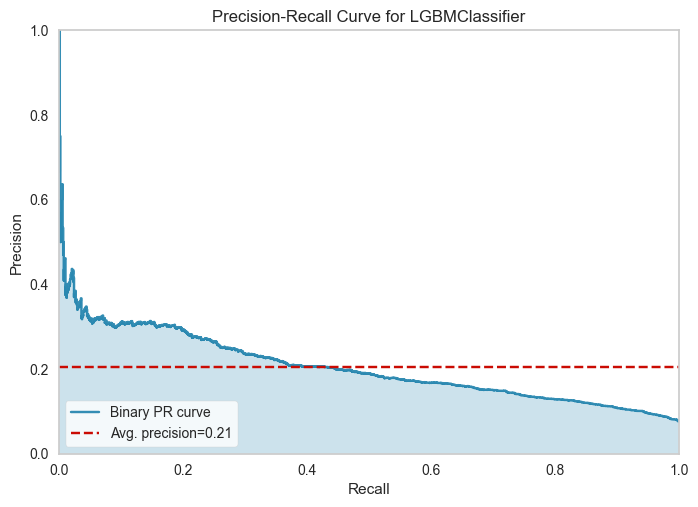

In [22]:
plot_model(tuned_lightgbm, plot = 'pr')

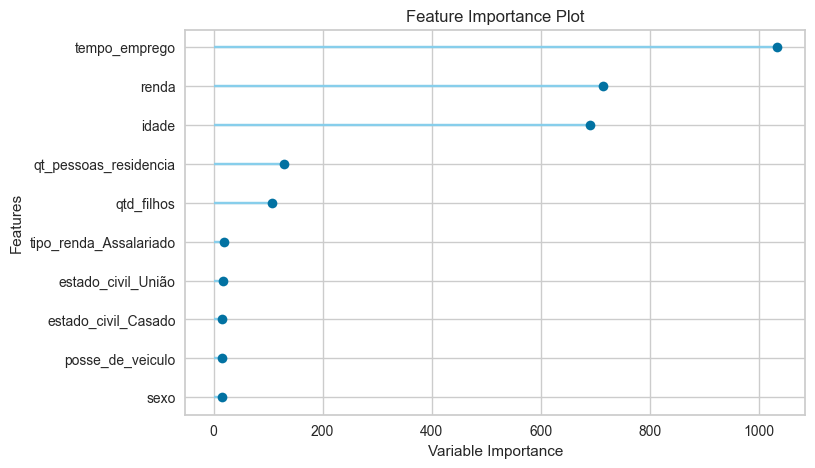

In [24]:
plot_model(tuned_lightgbm, plot='feature')

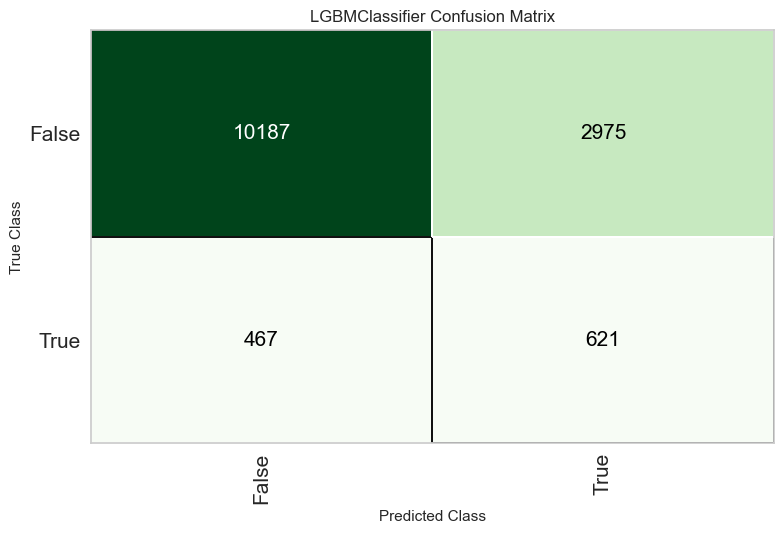

In [26]:
plot_model(tuned_lightgbm, plot='confusion_matrix')

In [30]:
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [35]:

predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7585,0.7497,0.5708,0.1727,0.2652,0.1676,0.2108


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
39415,F,N,N,0.0,Assalariado,Médio,União,Casa,31,9.131507,2.0,21447.550781,False,0,0.8962
36362,F,N,N,2.0,Assalariado,Superior completo,Casado,Com os pais,41,20.860273,4.0,34869.531250,False,0,0.9835
30483,F,N,S,0.0,Pensionista,Médio,Casado,Casa,62,NaN,2.0,5025.979980,False,0,0.6552
28073,F,S,N,1.0,Assalariado,Superior completo,União,Casa,37,2.684932,3.0,7976.609863,False,0,0.8930
24967,F,N,S,0.0,Assalariado,Médio,Casado,Casa,51,14.643836,2.0,73604.179688,False,0,0.9844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18353,M,S,S,0.0,Assalariado,Médio,Casado,Casa,52,21.380821,2.0,7805.660156,False,0,0.9629
37391,F,N,S,0.0,Pensionista,Superior completo,Casado,Casa,58,NaN,2.0,4569.930176,False,0,0.5487
14369,F,N,S,0.0,Assalariado,Médio,Casado,Casa,51,8.158904,2.0,8354.730469,False,1,0.5301
35261,M,N,S,0.0,Assalariado,Médio,Casado,Casa,54,16.356165,2.0,6797.240234,False,1,0.5186


In [37]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [39]:
print(final_lightgbm)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                boosting_type='gbdt', class_weight='balanced',
                     

In [41]:
predict_model(final_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7863,0.9014,0.8897,0.2487,0.3887,0.3058,0.3978


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [43]:
unseen_predictions = predict_model(final_lightgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7504,0.7712,0.6701,0.1910,0.2973,0.1991,0.2574


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,S,N,1,Assalariado,Superior completo,Casado,Aluguel,26,7.884932,3.0,11059.570312,False,1,0.6036
1,F,N,S,0,Assalariado,Médio,Casado,Casa,40,3.435616,2.0,11084.110352,False,0,0.5537
2,F,N,S,0,Pensionista,Superior completo,Casado,Casa,63,NaN,2.0,39297.488281,False,0,0.9573
3,F,N,S,0,Assalariado,Médio,Viúvo,Casa,54,6.531507,1.0,4761.390137,False,0,0.5322
4,M,S,N,0,Servidor público,Superior completo,Casado,Com os pais,28,4.526027,2.0,4321.319824,False,0,0.9413


In [47]:
save_model(final_lightgbm,'Final LightGBM Model 29nov2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight='balanced',
      